In [1]:
import numpy as np
from io import StringIO
import time,os, importlib, glob
from tqdm import tqdm
np.set_printoptions(linewidth=160)
import lib.ktn_io as kio
import lib.gt_tools as gt
from scipy.sparse import save_npz,load_npz, diags, eye, csr_matrix,bmat
from scipy.sparse.linalg import eigs,inv,spsolve
from scipy.sparse.csgraph import connected_components
import scipy as sp
import scipy.linalg as spla
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm

Using tqdm package for pretty progress bars!


In [488]:
def meig(M):
    nu,v,w = spla.eig(M,left=True)
    dp = np.diag(1.0/np.sqrt(np.diag((w.T@v).real)))
    nu,v,w = nu.real, (v.real@dp).T, w.real@dp
    return nu,v,w

def pt(M,p0,taur=[-4,4,800],ov=None,cdf=False):
    nu,v,w=meig(M)
    if ov is None:
        ov = np.ones(w.shape[0])
    wv = (ov@w) * (v@p0)
    tau = (wv / nu).sum()
    ta = np.logspace(taur[0],taur[1],taur[2])
    if cdf:
        pt = wv  @ (1.0-np.exp(-np.outer(nu,ta)*tau))
    else:
        pt = (wv * nu) @ np.exp(-np.outer(nu,ta)*tau)
    
    return nu.size, tau, ta, pt
    

# Load Data

In [467]:
data_path = "KTN_data/LJ38/4k"

beta = 1.0/0.125

# regroupfree group file
rgfgf = glob.glob(os.path.join(data_path,"*.T0.125/minima_groups.*"))

# regroupfree group thresh
rgfgt = [float(str(f.split(".")[0].split("/")[-1]+"."+f.split(".")[1])) for f in rgfgf]

Nmax = None

B, K, D, N, u, s, Emin, index_sel = kio.load_mat(path=data_path,beta=beta,Emax=None,Nmax=Nmax,screen=True)
D = np.ravel(K.sum(axis=0))
BF = beta*u-s
BF -= BF.min()
print(BF.max(),BF.min())

A_states,B_states = kio.load_AB(data_path,index_sel)

basins = B_states + A_states

inter_region = ~basins

names = ["oct","ico"]
print("\n\tFollowing truncation to connected network (removing %d states):" % ((~index_sel).sum()))
print("\n\tN_states:",N,"N_transitions:",K.data.size)
print("\n\t%d %s STATES <-> %d %s STATES" % (A_states.sum(),names[0],B_states.sum(),names[1]))
print("\n\tbeta:",beta,"\n\n")

N,N_TS: 4000 2653
Connected Clusters: 1620, 1st 400 states in largest cluster: 0
cc: N: 4000->900 (4000,) (4000,)
60.55264208454199 0.0

	Following truncation to connected network (removing 3100 states):

	N_states: 900 N_transitions: 2284

	5 oct STATES <-> 128 ico STATES

	beta: 8.0 




# REGROUPFREE (LEA) groupings

In [197]:
groups = {} # map

index_map = np.zeros(index_sel.size,int)
index_map[index_sel] = np.arange(N)

for ft in zip(rgfgf,rgfgt):
    groupid = 0
    groupmem = np.zeros(N,int)
    f = open(ft[0],'r')
    print(ft[0])
    
    members = []
    for line in f.readlines():
        if len(line)==2:
            continue
        fields = line.strip().split(" ")
  
        if fields[0]=="group":
            for m in members:
                if index_sel[m]:
                    groupmem[index_map[m]] = groupid
            groupid += 1
            members=[]
        else:
            members.append(int(line.strip())-1)
    f.close()
    groups[ft[1]] = groupmem.copy()
    
    occs = np.unique(groups[ft[1]],return_counts=True)[1]
    new_N = occs.size
    
    print(ft[1],groupid,new_N,(occs>1).sum(),occs.max())


KTN_data/LJ38/4k/0.95.T0.125/minima_groups.0.1250000000
0.95 444 444 100 82
KTN_data/LJ38/4k/0.1.T0.125/minima_groups.0.1250000000
0.1 790 790 76 6
KTN_data/LJ38/4k/0.75.T0.125/minima_groups.0.1250000000
0.75 505 505 104 62
KTN_data/LJ38/4k/0.5.T0.125/minima_groups.0.1250000000
0.5 620 620 110 30


# Spectral coarsening from a given clustering

In [496]:
def spectral_coarsen(cluster_occupation,rate_matrix,boltz_dist,start_dist,obs_err=0.01,
                     LEA=False,nmodes=2,cdf=False,boltz_rotate=True):
    """
    Default option, mode_thresh=0, gives LEA
    """
    
    groups,occs = np.unique(cluster_occupation,return_counts=True)
    new_N = groups.size
    old_N = cluster_occupation.size
    
    proj_X = []
    proj_Y = []
    
    
    projections=[]
    
    proj_c = np.zeros(new_N)
    
    for i,gid in enumerate(groups):
        gsel = cluster_occupation==gid
        
        if LEA or gsel.sum()<2:
            proj_X.append( boltz_dist * gsel / boltz_dist[gsel].sum())
            proj_Y.append( gsel )
            proj_c[i]+=1.0
            continue
        
        # cluster block
        bM = rate_matrix[gsel,:][:,gsel].todense()
        brho = boltz_dist[gsel] / boltz_dist[gsel].sum()
        
        Q = np.identity(gsel.sum()) - np.outer(brho,np.ones(gsel.sum()))
        
        nu,v,w = meig(bM)
        
        wv = (w.sum(axis=0)) * (v@brho)
        
        
        ltauv = np.zeros((wv.size,nmodes+2))
        ltauv[:,0] = wv * nu / (wv*nu).sum()
        ltauv[:,1] = wv
        
        for inm in range(nmodes):
            lv = wv / nu**(inm+1)
            ltauv[:,inm+2] = lv/lv.sum()
        reconst = np.zeros(ltauv.shape[1])
        
        
        if obs_err==0.0:
            evorder = np.abs(wv).argsort()[::-1]
        else:
            evorder = np.abs(ltauv.prod(axis=1)).argsort()[::-1]
            
        for evind in evorder:
            vecs = np.zeros((old_N,2))
            if boltz_rotate:
                if evind == wv.argmax():
                    vecs[gsel,0] = brho
                    vecs[gsel,1] = np.ones(brho.size)
                else:
                    vecs[gsel,0] = w[:,evind] - w[:,evind].sum()*brho
                    vecs[gsel,1] = v[evind,:] - v[evind,:]@brho  * np.ones(brho.size)
            else:
                vecs[gsel,0] = w[:,evind]
                vecs[gsel,1] = v[evind,:]
                
            
            
            reconst += ltauv[evind]
            proj_X.append(vecs[:,0])
            proj_Y.append(vecs[:,1])
            proj_c[i]+=1.0
            if np.abs(reconst-1.0).max()<obs_err:
                #print(reconst)
                break
            
            

    proj_X = np.r_[proj_X].T
    proj_Y = np.r_[proj_Y]
    
    new_rate_matrix = proj_Y@rate_matrix.todense()@proj_X
    new_start_dist = proj_Y@start_dist
    new_ov = proj_X.sum(axis=0)
    N_cg,tau_cg,ta,p_cg = pt(new_rate_matrix,new_start_dist,ov=new_ov,cdf=cdf)
    return N_cg,tau_cg,ta,p_cg,proj_c
    
        

# Waiting time distribution

tau: 2744845596.6445646 1.0012432317167332 0.08377094671405817 0.05085473622906653 0.719203269994055
tau: 871997946.838297 1.0000000207409672 0.062117758103588466 0.5278783610872807 0.7819242395664222


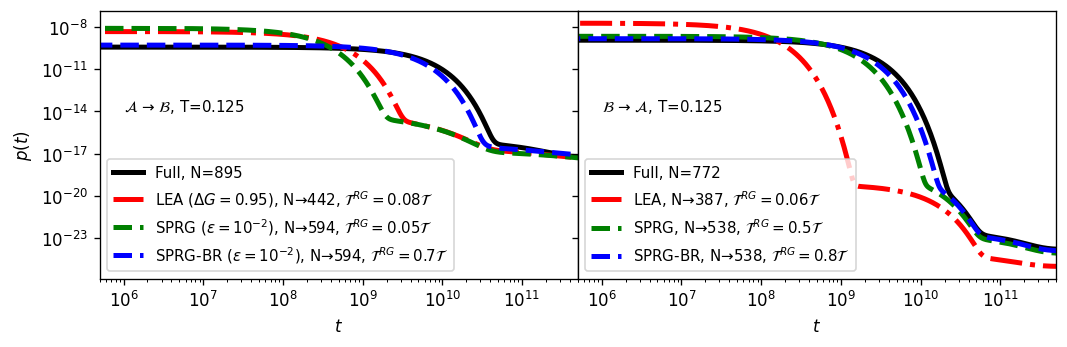

In [514]:
fig,axs = plt.subplots(1,2,figsize=(9,3),dpi=120,sharey=True)
for k in [0,1]:
    ax = axs[k]
    
    ssel = [~A_states,~B_states]
    
    #ax.set_title(r"%s$\to$%s (from %d$\to$%d states), T=%2.4g" 
    #             % (names[k],names[1-k],(~ssel[k]).sum(),(~ssel[1-k]).sum(),1.0/beta))
    
    ssel = ssel[k]
    
    ico_D = diags(D[ssel])
    ico_K = K[ssel,:][:,ssel].copy()
    ico_K.eliminate_zeros()
    
    
    # Initial Dist
    rho0 = (np.exp(-BF+BF.min()) * [B_states,A_states][k])[ssel]
    rho0 /= rho0.sum()
    
    # Boltz Dist
    rho = np.exp(-BF+BF.min())[ssel]
    rho /= rho.sum()
    
    ptau = spsolve(ico_D-ico_K,rho0).sum()
    
    N_raw,tau,ta,p_raw,proj_c = spectral_coarsen(groups[rg][ssel],ico_D-ico_K,rho,rho0,LEA=False,
                                                          obs_err=0.0,nmodes=1,boltz_rotate=True)
    ax.plot(ta*tau,p_raw,'k-',label=r"Full, N=%d" % (N_raw),lw=3)
    
    rg=0.95
    ep=-2
    
    # LEA
    N_cg,tau_lea,ta,p_lea,proj_c = spectral_coarsen(groups[rg][ssel],ico_D-ico_K,rho,rho0,LEA=True)
    if k==0:
        label=r"LEA ($\Delta{G}=%1.2g$), N$\to$%d, $\mathcal{T}^{RG}=%2.1g\mathcal{T}$" % (rg,N_cg,tau_lea/ptau)
    else:
        label=r"LEA, N$\to$%d, $\mathcal{T}^{RG}=%2.1g\mathcal{T}$" % (N_cg,tau_lea/tau)
    ax.plot(ta*tau_lea,p_lea,'r-.',label=label,lw=3)
    
    # SPRG
    N_cg,tau_sprg1,ta,p_sprg,proj_c = spectral_coarsen(groups[rg][ssel],ico_D-ico_K,rho,rho0,LEA=False,
                                                          obs_err=10.0**ep,nmodes=1,boltz_rotate=False)
    rtau = tau_sprg1/ptau
    if k==0:
        label=r"SPRG ($\epsilon=10^{%d}$), N$\to$%d, $\mathcal{T}^{RG}=%2.1g\mathcal{T}$" % (ep,N_cg,rtau)
    else:
        label=r"SPRG, N$\to$%d, $\mathcal{T}^{RG}=%2.1g\mathcal{T}$" % (N_cg,rtau)     
    ax.plot(ta*tau_sprg1,p_sprg,'g--',label=label,lw=3)
    
    # SPRG, BR
    N_cg,tau_sprg,ta,p_sprg,proj_c = spectral_coarsen(groups[rg][ssel],ico_D-ico_K,rho,rho0,LEA=False,
                                                          obs_err=10.0**ep,nmodes=1,boltz_rotate=True)
    rtau = tau_sprg/ptau
    if k==0:
        label=r"SPRG-BR ($\epsilon=10^{%d}$), N$\to$%d, $\mathcal{T}^{RG}=%2.1g\mathcal{T}$" % (ep,N_cg,rtau)
    else:
        label=r"SPRG-BR, N$\to$%d, $\mathcal{T}^{RG}=%2.1g\mathcal{T}$" % (N_cg,rtau)     
    ax.plot(ta*tau_sprg,p_sprg,'b--',label=label,lw=3)
    
    print("tau:",ptau,tau/ptau,tau_lea/ptau,tau_sprg1/ptau,tau_sprg/ptau)

    names=[r"$\mathcal{A}$",r"$\mathcal{B}$"]
    ax.set_xlabel(r"$t$")
    
    ax.text(1e6,1e-14,names[k]+r" $\to$ "+names[1-k] + ", T=%2.4g" % (1.0/beta),fontsize=9)
    
    if k==0:
        ax.set_ylabel(r"$p(t)$")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlim(5e5,5e11)

    ax.legend(loc="lower left",fontsize=9)

    #print("\n",res[0],res[1],res[2],res[3].size)
plt.tight_layout()
plt.subplots_adjust(wspace=0.0,hspace=0.0)
plt.savefig("spectral_regroup_T%2.2g.pdf" % (1.0/beta))
